# 📝 Exercise M6.04

The aim of the exercise is to get familiar with the histogram
gradient-boosting in scikit-learn. Besides, we will use this model within
a cross-validation framework in order to inspect internal parameters found
via grid-search.

We will use the California housing dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

First, create a histogram gradient boosting regressor. You can set the
trees number to be large, and configure the model to use early-stopping.

In [5]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_grad_boost = HistGradientBoostingRegressor(max_iter=200, random_state=0, early_stopping=True)

In [6]:
hist_grad_boost.get_params()

{'categorical_features': None,
 'early_stopping': True,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 200,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 0,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

We will use a grid-search to find some optimal parameter for this model.
In this grid-search, you should search for the following parameters:

* `max_depth: [3, 8]`;
* `max_leaf_nodes: [15, 31]`;
* `learning_rate: [0.1, 1]`.

Feel free to explore the space with additional values. Create the
grid-search providing the previous gradient boosting instance as the model.

In [7]:
param_grid = {"max_depth": [3, 8],
"max_leaf_nodes": [15, 31],
"learning_rate": [0.1, 1]}

from sklearn.model_selection import GridSearchCV
model_gridCV = GridSearchCV(hist_grad_boost, param_grid=param_grid, n_jobs=2)

Finally, we will run our experiment through cross-validation. In this regard,
define a 5-fold cross-validation. Besides, be sure to shuffle the data.
Subsequently, use the function `sklearn.model_selection.cross_validate`
to run the cross-validation. You should also set `return_estimator=True`,
so that we can investigate the inner model trained via cross-validation.

In [8]:
from sklearn.model_selection import cross_validate, ShuffleSplit

shuffle_split = ShuffleSplit(n_splits=5, random_state=0)
cv_results = cross_validate(model_gridCV, data, target, cv=shuffle_split, return_estimator=True, n_jobs=2)

In [29]:
# Solution:

from sklearn.model_selection import cross_validate, KFold

Kfold = KFold(n_splits=5, shuffle=True, random_state=0)
cv_results = cross_validate(model_gridCV, data, target, cv=Kfold, return_estimator=True, n_jobs=2)

Now that we got the cross-validation results, print out the mean and
standard deviation score.

In [11]:
f"{cv_results['test_score'].mean():.3f} +/- {cv_results['test_score'].std():.3f}"

'0.847 +/- 0.008'

Then inspect the `estimator` entry of the results and check the best
parameters values. Besides, check the number of trees used by the model.

In [24]:
for each in cv_results['estimator']:
    print(each.best_params_)
    print(each.best_estimator_.n_iter_)

{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 31}
200
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 31}
200
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 31}
200
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 31}
200
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 31}
200


In [23]:
cv_results['estimator'][0].cv_results_

{'mean_fit_time': array([1.56307478, 1.36956873, 3.05890765, 5.43581905, 0.46094236,
        0.5347918 , 0.55707617, 0.47116485]),
 'std_fit_time': array([0.14510007, 0.02389819, 0.18549462, 0.24966136, 0.12590507,
        0.15266848, 0.12605164, 0.05712   ]),
 'mean_score_time': array([0.06080923, 0.04889941, 0.04544301, 0.05318351, 0.01332946,
        0.01360631, 0.01235418, 0.00764675]),
 'std_score_time': array([0.02194224, 0.01493111, 0.00667392, 0.01457262, 0.00274148,
        0.00358344, 0.00509795, 0.00158652]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3, 3, 8, 8, 3, 3, 8, 8],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_leaf_nodes': masked_array(data=[15, 31, 15, 31, 15, 31, 15, 31],

Inspect the results of the inner CV for each estimator of the outer CV.
Aggregate the mean test score for each parameter combination and make a box
plot of these scores.

In [30]:
# solution
import pandas as pd

index_columns = [f"param_{name}" for name in param_grid.keys()]
columns = index_columns + ["mean_test_score"]

inner_cv_results = []
for cv_idx, estimator in enumerate(cv_results["estimator"]):
    search_cv_results = pd.DataFrame(estimator.cv_results_)
    search_cv_results = search_cv_results[columns].set_index(index_columns)
    search_cv_results = search_cv_results.rename(
        columns={"mean_test_score": f"CV {cv_idx}"})
    inner_cv_results.append(search_cv_results)
inner_cv_results = pd.concat(inner_cv_results, axis=1).T

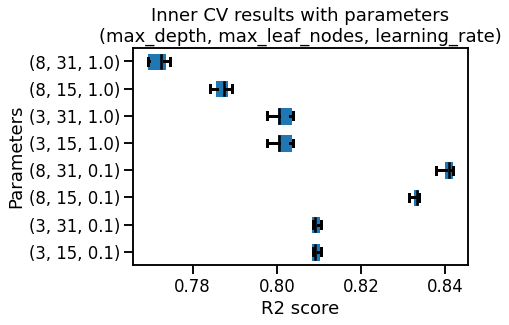

In [28]:
# solution version 1 using Shuffle Split
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parameters")
_ = plt.title("Inner CV results with parameters\n"
              "(max_depth, max_leaf_nodes, learning_rate)")

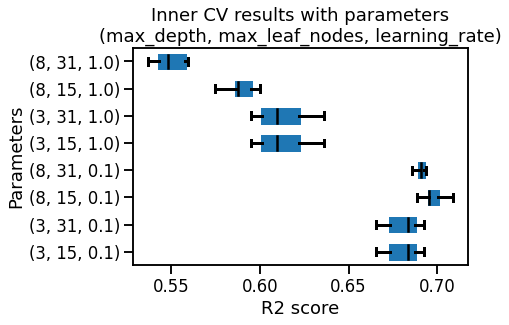

In [31]:
# solution version 2 using K-Fold
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parameters")
_ = plt.title("Inner CV results with parameters\n"
              "(max_depth, max_leaf_nodes, learning_rate)")